In [1]:
# !pip install -e /home/jovyan/scale-aware-air-sea/scale-aware-air-sea

In [3]:
#TODO: I want attrs to propagate through...need to start in the first step though...

#TOD: I need to filter the ice reagions out in the first step (saves a lot of air-sea compute?)

In [4]:
# from dask_gateway import Gateway
# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()
# print('setting up new cluster')

# options = gateway.cluster_options()
# # options.environment = dict(
# #     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0",
# # )
# # options.worker_memory = 12
# # options.worker_cores = 2
# options.worker_memory = 50 
# options.worker_cores = 12

# # options

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()

# # cluster.adapt(10, 200)
# # cluster.scale(200)
# cluster.scale(30)
# client

In [5]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=4) # product of these 2 numbers should be =< # of cores
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/8787/status,
Dashboard: /user/jbusecke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35089,Workers: 4
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:36845,Total threads: 4
Dashboard: /user/jbusecke/proxy/41375/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:36065,


In [6]:
import gcsfs
import xarray as xr
import numpy as np
from scale_aware_air_sea.utils import filter_inputs_dataset, to_zarr_split, open_zarr, weighted_coarsen
from scale_aware_air_sea.parameters import get_params

In [7]:
fs = gcsfs.GCSFileSystem()
primary_algo = 'ecmwf'

# load global parameters
params = get_params('v0.7.0', test=False) 

mapper_filter_fluxes = fs.get_mapper(params['paths']['CESM']['filter_fluxes'])
# mapper_coarse_fluxes = fs.get_mapper(params['paths']['CESM']['coarse_fluxes'])

mapper_filter_flux_decomposition_monthly = fs.get_mapper(params['paths']['CESM']['filter_decomposition_monthly'])
mapper_coarse_flux_decomposition_monthly = fs.get_mapper(params['paths']['CESM']['coarse_decomposition_monthly'])

# mapper_filter_flux_decomposition_daily = fs.get_mapper(params['paths']['CESM']['filter_decomposition_daily'])
# mapper_coarse_flux_decomposition_daily = fs.get_mapper(params['paths']['CESM']['coarse_decomposition_daily'])
# mapper_filter_flux_decomposition_daily_appendix = fs.get_mapper(params['paths']['CESM']['filter_decomposition_daily_appendix'])

# mapper_filter_flux_decomposition_mean = fs.get_mapper(params['paths']['CESM']['filter_decomposition_mean'])
# mapper_coarse_flux_decomposition_mean = fs.get_mapper(params['paths']['CESM']['coarse_decomposition_mean'])

#mapper_ice_mask = fs.get_mapper(params['paths']['CESM']['ice_mask'])

save_vars = ['ql', 'qh']

KeyError: 'filter_fluxes'

In [4]:
# new scale separation
def decomposition_filter(ds, output_terms):
    """Decomposing filtered flux outputs into different terms to evaluate"""
    def filt(ds):
        return filter_inputs_dataset(ds, ['nlat_t', 'nlon_t'], params['filter_scale'])
    
    # all possible terms: ['Q_H', 'Q_H_bar', 'Q_L', 'Q_L_bar']
    
    # ['Q_star', `Q_star_star`, 'Q_star_star_ocean', 'Q_star_star_atmos']
    
    tdict = {}
    
    # Q_H (AB) - high resolution input
    tdict['Q_H'] = ds.sel(smoothing='smooth_none')
    tdict['Q_H_bar'] = filt(tdict['Q_H'])
    # Q_L low resolution input
    tdict['Q_L'] = ds.sel(smoothing='smooth_all')
    tdict['Q_L_bar'] = filt(tdict['Q_L'])
    tdict['Q_L_prime'] = tdict['Q_L'] - tdict['Q_L_bar'] # TODO: I could potentially compute this on the fly...
    
    # Inferred Small scale
    tdict['Q_star'] = tdict['Q_H_bar'] - tdict['Q_L']
    tdict['Q_star_star'] = tdict['Q_H_bar'] - tdict['Q_L_bar']
    
    # mixed low resolution input
#     tdict['Q_L_ocean'] = ds.sel(smoothing='smooth_vel_tracer_ocean')
#     tdict['Q_L_ocean_bar'] = filt(tdict['Q_L_ocean'])
    
#     tdict['Q_L_atmos'] = ds.sel(smoothing='smooth_vel_tracer_atmos')
#     tdict['Q_L_atmos_bar'] = filt(tdict['Q_L_atmos'])
    
#     #tdict['Q_star_ocean'] = tdict['Q_H_bar'] - tdict['Q_L_ocean']
#     #tdict['Q_star_ocean_bar'] = filt(tdict['Q_star_ocean'])
#     tdict['Q_star_star_ocean'] = tdict['Q_H_bar'] - tdict['Q_L_ocean_bar']
    
#     #tdict['Q_star_atmos'] = tdict['Q_H_bar'] - tdict['Q_L_atmos']
#     #tdict['Q_star_atmos_bar'] = filt(tdict['Q_star_atmos'])
#     tdict['Q_star_star_atmos'] = tdict['Q_H_bar'] - tdict['Q_L_atmos_bar']
    
    #tdict['Q_star_res_wrong'] = tdict['Q_star'] - tdict['Q_star_star_ocean'] - tdict['Q_star_star_atmos']
    #tdict['Q_star_res'] = tdict['Q_star'] - tdict['Q_star_ocean'] - tdict['Q_star_atmos']
    #tdict['Q_star_star_res'] = tdict['Q_star_star'] - tdict['Q_star_star_ocean'] - tdict['Q_star_star_atmos'] 
    
    # for testing
    #tdict['Q_H_bar_bar'] = filt(tdict['Q_H_bar'])
    #tdict['Q_star_star_star'] = tdict['Q_H_bar_bar'] - tdict['Q_L_bar']
    #tdict['Q_star_res'] = tdict['Q_star'] - tdict['Q_star_ocean'] - tdict['Q_star_atmos']
    
    # concat into a single dataset
    datasets = [tdict[t].assign_coords(term=t).drop([dvar for dvar in ['smoothing'] if dvar in tdict[t]]) for t in output_terms]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds.attrs
    return ds_out


# def decomposition_coarse(ds_filter, ds_coarse):
#     def smooth(ds):
#         return weighted_coarsen(
#             ds, 
#             {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
#             'area_t'
#         )
    
#     decomp = {}
#     # Q_H (AB) - high resolution input
#     Q_H = ds_filter.sel(smoothing='smooth_none') # dont include in dict, because it has different size
#     decomp['Q_H_bar'] = smooth(Q_H)
#     # Q_L low resolution input
#     decomp['Q_L'] = ds_coarse.sel(smoothing='smooth_all')

    
#     # Inferred Small scale
#     decomp['Q_star'] = decomp['Q_H_bar'] - decomp['Q_L']
    
#     # concat into a single dataset
#     datasets = [ds.drop([dvar for dvar in ['smoothing'] if dvar in ds]).assign_coords(term=k) for k,ds in decomp.items()]
#     ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
#     ds_out.attrs = ds_coarse.attrs
#     return ds_out

## TODO: FOr now all coarse stuff is deactivated 
- move the masking to the beginning
- Also decide how much of the coarsened stuff we need (maybe this should also just be a thing like the appendix 2 year daily array?)

In [6]:
ds_filter_fluxes = open_zarr(mapper_filter_fluxes)[save_vars]
# ds_coarse_fluxes = open_zarr(mapper_coarse_fluxes, chunks={'time':3000})[save_vars]

In [7]:
ds_filter_fluxes

<xarray.Dataset>
Dimensions:             (algo: 2, smoothing: 2, time: 730, nlat_t: 2400,
                         nlon_t: 3600)
Coordinates: (12/44)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sflux_factor        float64 ...
  * smoothing           (smoothing) <U11 'smooth_none' 'smooth_all'
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 ...
Data variables:
    ql                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    qh                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>

## Filter ice regions (this should be moved to step 1 eventually)
That would also make the coarse stuff comparable again (currently it is not really since we have no aggregated mask - I could do that but that seems like a waste of time here)

In [8]:
ice_mapper = fs.get_mapper('gs://leap-scratch/jbusecke/scale-aware-air-sea/temp/CESM_icemask_SST_gt_2.zarr')
ice_mapper

In [9]:
ice_mask = open_zarr(ice_mapper)

In [9]:
ice_mask

<xarray.Dataset>
Dimensions:  (time: 730, nlat_t: 2400, nlon_t: 3600)
Coordinates:
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * time     (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:00:00
Data variables:
    SST      (time, nlat_t, nlon_t) bool dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

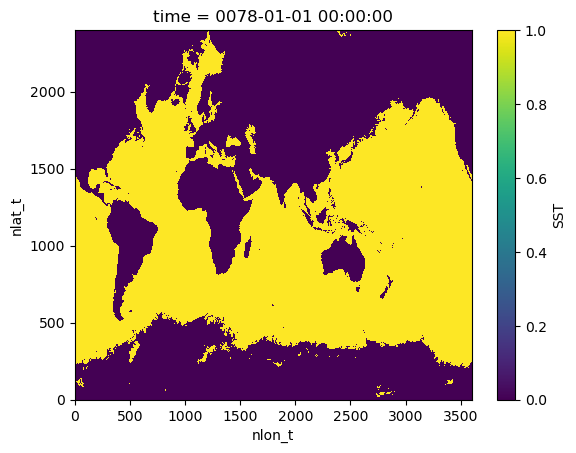

In [26]:
ice_mask.SST.isel(time=0).plot()

In [10]:

#ds_ice_mask = open_zarr(mapper_ice_mask)
ds_filter_fluxes = ds_filter_fluxes.where(ice_mask.SST) #.isel(time=slice(0,30)))
# There is some weird thing happening here if I do not drop the coords...
# It seems like the coordinates in the ice_mask were not rechunked properly (they are still chunked in space...) and that somehow 
# makes xarray drop them in the result? 
# could not reproduce with simple example. 
# import numpy as np
# import xarray as xr
# import dask.array as dsa

# nx = 10
# data = dsa.random.random((nx, 3), chunks=(nx, 1))
# data_mask = dsa.random.random((nx, 3), chunks=(nx, 1))
# x = np.arange(nx)
# other = dsa.from_array(x+4, chunks=(nx))
# other_chunked = dsa.from_array(x+4, chunks=(3))

# ds = xr.DataArray(data, dims=['x', 'time'], coords={'x':x, 'other':(['x'], other)}).to_dataset(name='data')
# # 
# da_mask = xr.DataArray(data_mask, dims=['x', 'time'], coords={'x':x, 'other':(['x'], other_chunked)})
# ds.where(da_mask>0.2)

# Might be worth looking into at a later point, but for now moving on due to time constraints

In [11]:
ds_filter_fluxes

<xarray.Dataset>
Dimensions:             (algo: 2, smoothing: 2, time: 730, nlat_t: 2400,
                         nlon_t: 3600)
Coordinates: (12/44)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sflux_factor        float64 ...
  * smoothing           (smoothing) <U11 'smooth_none' 'smooth_all'
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 ...
Data variables:
    ql                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    qh                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>

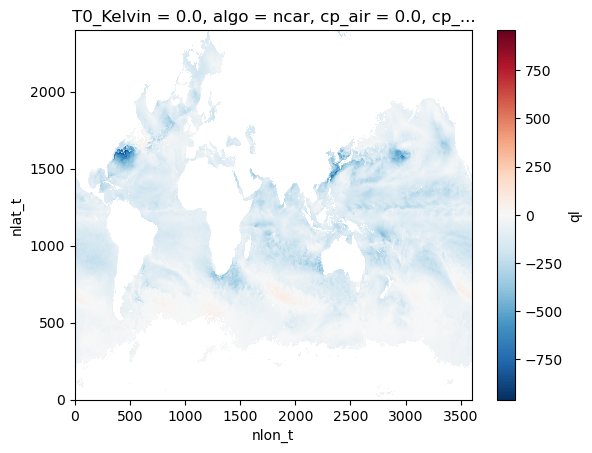

In [12]:
ds_filter_fluxes.isel(time=0, algo=0, smoothing=0).ql.plot()

## Take means

In [13]:
# long terms means of both
# ds_coarse_fluxes_mean = ds_coarse_fluxes.mean('time')
ds_filter_fluxes_mean = ds_filter_fluxes.mean('time')

In [14]:
# persist the means to reduce computation later
# ds_coarse_fluxes_mean = ds_coarse_fluxes_mean.persist()
ds_filter_fluxes_mean = ds_filter_fluxes_mean.persist()

In [12]:
ds_filter_fluxes_monthly = ds_filter_fluxes.resample(time='1MS').mean()
# ds_coarse_fluxes_monthly = ds_coarse_fluxes.resample(time='1MS').mean()

In [15]:
filter_decomp_mean = decomposition_filter(
    ds_filter_fluxes_mean,
    ['Q_star', 'Q_star_star', 'Q_H_bar', 'Q_L_bar']
)

In [20]:
# coarse_decomp_mean = decomposition_coarse(ds_filter_fluxes_mean, ds_coarse_fluxes_mean)
# # Some checks in the weighted coarsen trigger computation for the first slice (which here is the full dataset). 
# # I persisted both above to only do that once.
# coarse_decomp_mean

In [13]:
# I have an appendix array with all algos, lets save some time and space and only use our reference algo
filter_decomp_monthly = decomposition_filter(ds_filter_fluxes_monthly.sel(algo=primary_algo), ['Q_star_star','Q_H_bar'])

In [14]:
filter_decomp_monthly

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, time: 24, term: 2)
Coordinates: (12/44)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-01 00:0...
  * term                (term) <U11 'Q_star_star' 'Q_H_bar'
Data variables:
    ql                  (term, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>
    qh                  (term, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>

In [22]:
# coarse_decomp_monthly = decomposition_coarse(ds_filter_fluxes_monthly, ds_coarse_fluxes_monthly)

In [42]:
# coarse_decomp_daily = decomposition_coarse(ds_filter_fluxes.sel(algo=primary_algo), ds_coarse_fluxes.sel(algo=primary_algo))
filter_decomp_daily = decomposition_filter(
    ds_filter_fluxes.sel(algo=primary_algo), 
    ['Q_star_star']
)

In [24]:
# 2 year only but with all algos for the appendix
filter_decomp_daily_appendix = decomposition_filter(
    ds_filter_fluxes.sel(time=slice('0181-01-01', '0183-01-01')), 
    ['Q_star_star', 'Q_star_star_ocean', 'Q_star_star_atmos'] # for the case_study.ipynb
)
filter_decomp_daily_appendix

<xarray.Dataset>
Dimensions:   (algo: 5, yt_ocean: 2700, xt_ocean: 3600, time: 731, term: 3)
Coordinates: (12/13)
  * algo      (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...        ...
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-01 12:00:00 ... 0183-01-01 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * term      (term) <U17 'Q_star_star' 'Q_star_star_ocean' 'Q_star_star_atmos'
Data variables:
    ql        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

### Save out all decompositions

In [25]:
# fs.rm(mapper_filter_flux_decomposition_mean.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_mean.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_daily.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_daily_appendix.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_daily.root, recursive=True)
# fs.rm(mapper_filter_flux_decomposition_monthly.root, recursive=True)
# fs.rm(mapper_coarse_flux_decomposition_monthly.root, recursive=True)

In [15]:
for ds, mapper, msg in [
    # (filter_decomp_mean, mapper_filter_flux_decomposition_mean, 'Long Term Mean Filter'),
    # (coarse_decomp_mean, mapper_coarse_flux_decomposition_mean, 'Long Term Mean Coarse'),
    (filter_decomp_monthly, mapper_filter_flux_decomposition_monthly, 'Montlhy Filter'),
    # (coarse_decomp_monthly, mapper_coarse_flux_decomposition_monthly, 'Montlhy Coarse'),
    # (filter_decomp_daily_appendix, mapper_filter_flux_decomposition_daily_appendix, 'Daily Filter (all algos for appendix)'),
    # (filter_decomp_daily, mapper_filter_flux_decomposition_daily, 'Daily Filter'),
    # (coarse_decomp_daily, mapper_coarse_flux_decomposition_daily, 'Daily Coarse'),
]:
    # datasets 'tests'
    # assert 'geolon_t' in ds
    # assert 'geolat_t' in ds
    
    
    # cluster.scale(200) # if some workers got lost? This might not be the best place to reset this...
    for va in ds.variables:
        if 'chunks' in ds[va].encoding.keys():
            # print(va)
            del ds[va].encoding['chunks']

    print(f"Saving {msg}: {ds.nbytes/1e9}GB")
    if 'time' in ds.dims:
        to_zarr_split(
            ds,
            mapper,
            # split_interval=50 if 'algo' in ds.dims else 150
            split_interval=150 if 'algo' in ds.dims else 450
            # split_interval=60 # less memory pressure on the scheduler. Set back to 60 when using dask-gateway...
        )
    else:
        ds.to_zarr(mapper)

Saving Montlhy Filter: 3.93988854GB
Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CESM_fluxes_filter_decomposed_monthly_v0.7.0.zarr ...


0it [00:00, ?it/s]

In [46]:
filter_decomp_mean

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, algo: 2, term: 4)
Coordinates: (12/43)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 0.0
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
  * term                (term) <U11 'Q_star' 'Q_star_star' 'Q_H_bar' 'Q_L_bar'
Data variables:
    ql                  (term, algo, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>
    qh                  (term, algo, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>

In [16]:
%%time
filter_decomp_mean.to_zarr(mapper_filter_flux_decomposition_mean)

CPU times: user 19 s, sys: 2 s, total: 21 s
Wall time: 2min 46s


In [51]:
# to_zarr_split(filter_decomp_daily, mapper_filter_flux_decomposition_daily, split_interval=150)

Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CESM_fluxes_filter_decomposed_daily_v0.7.0test.zarr ...


  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
ds = open_zarr(mapper_filter_flux_decomposition_mean)

In [50]:
ds

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, algo: 2, term: 4)
Coordinates: (12/43)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * term                (term) <U11 'Q_star' 'Q_star_star' 'Q_H_bar' 'Q_L_bar'
    vonkar              float64 ...
Data variables:
    qh                  (term, algo, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>
    ql                  (term, algo, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 2400, 3600), meta=np.ndarray>

In [9]:
ds.qh.isel(xt_ocean=2000, yt_ocean=1000).plot()


KeyboardInterrupt



In [13]:
# cluster.shutdown()